In [22]:
#from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import Series

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from functools import reduce
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 14

%matplotlib inline

In [23]:
train = '../data/train.csv'
test = '../data/test.csv'
index_col = 'Id'

data = pd.read_csv(train,index_col = index_col )
evaluate = pd.read_csv(test,index_col = index_col )

data.sort_index(inplace = True)
evaluate.sort_index(inplace = True)



print(data.shape) #(R,C)
print(evaluate.shape) #(R,C)

(2051, 80)
(879, 79)


In [24]:
#Sum columns for total SQFT
data['Total_sqft']= data[['1st Flr SF','2nd Flr SF','BsmtFin SF 1','BsmtFin SF 2','Gr Liv Area']].sum(axis =1)
evaluate['Total_sqft']= evaluate[['1st Flr SF','2nd Flr SF','BsmtFin SF 1','BsmtFin SF 2','Gr Liv Area']].sum(axis =1)


#use this instead of dummy variable
#data['Derived_Condition']= data[['Overall Qual','Overall Cond']].sum(axis =1)
#evaluate['Derived_Condition']= evaluate[['Overall Qual','Overall Cond']].sum(axis =1)

#normalize years but subtracting from 2019
data['Age_Build'] = 2019 - data['Year Built']
data['Age_Remodel'] = 2019 - data['Year Remod/Add']

evaluate['Age_Build'] = 2019 - evaluate['Year Built']
evaluate['Age_Remodel'] = 2019 - evaluate['Year Remod/Add']


#use all the available Condition and quality indicators f
categorical_features = ['Overall Qual','Overall Cond', 'Exter Qual', 'Exter Cond', 'Garage Qual', 'Garage Cond', 'Bsmt Qual', 'Bsmt Cond', 'Kitchen Qual',]

data = pd.get_dummies(data=data, columns = categorical_features)
evaluate = pd.get_dummies(data=evaluate, columns = categorical_features)



In [25]:
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'), dtype('uint8')],
      dtype=object)

In [26]:
# get all numerical columns to float64
final = ['float64']
other =['uint8','int16', 'int32', 'int64', 'float16', 'float32']

D_to_convert = data.select_dtypes(include=other).columns
E_to_convert = evaluate.select_dtypes(include=other).columns


for i in D_to_convert:
    data[i] = data[i].astype('float64')
    
for i in E_to_convert:
    evaluate[i] = evaluate[i].astype('float64')

In [27]:
numerical = data.select_dtypes(include='float64').columns
other = data.select_dtypes(include='object').columns
print('Numerical Columns:', len(numerical))
print('Object Columns:', len(other))

Numerical Columns: 91
Object Columns: 35


In [28]:
null_df = pd.DataFrame(data.isnull().sum().sort_values(ascending=False),columns=['Null_Count'])
null_df[null_df['Null_Count'] >0]


,Null_Count
Pool QC,2042
Misc Feature,1986
Alley,1911
Fence,1651
Fireplace Qu,1000
Lot Frontage,330
Garage Finish,114
Garage Yr Blt,114
Garage Type,113
Bsmt Exposure,58


In [29]:
data['Garage Cars'].fillna(value=data['Garage Cars'].mean(),inplace = True)
evaluate['Garage Cars'].fillna(value=evaluate['Garage Cars'].mean(),inplace = True)


data['Garage Area'].fillna(value=data['Garage Area'].mean(),inplace = True)
evaluate['Garage Area'].fillna(value=evaluate['Garage Area'].mean(),inplace = True)

data['Total Bsmt SF'].fillna(value=data['Total Bsmt SF'].mean(),inplace = True)
evaluate['Total Bsmt SF'].fillna(value=evaluate['Total Bsmt SF'].mean(),inplace = True)

print(data.shape)
print(evaluate.shape)

(2051, 126)
(879, 122)


''

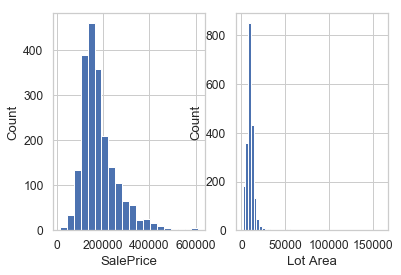

In [30]:
#histogram
fig, (ax1, ax2) = plt.subplots(ncols=2)
    
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [17,10]})
sns.distplot(
    data['SalePrice'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1},ax=ax1
).set(xlabel='SalePrice', ylabel='Count')



sns.distplot(
    data['Lot Area'], norm_hist=False, kde=False,  hist_kws={"alpha": 1},ax=ax2
).set(xlabel='Lot Area', ylabel='Count')
;

In [31]:
data[['SalePrice','Lot Area','Total_sqft']].sort_values(by=['Total_sqft'],ascending = False).head(15)

,SalePrice,Lot Area,Total_sqft
Id,,,
1499,160000.0,63887.0,16928.0
2181,183850.0,39290.0,14200.0
2451,584500.0,17242.0,8685.0
16,538000.0,53504.0,7974.0
254,320000.0,12376.0,7914.0
2738,415000.0,19800.0,7769.0
1773,430000.0,12692.0,7687.0
1498,284700.0,47007.0,7640.0
1861,373000.0,17778.0,7455.0


In [32]:

#remove some outliers. Not exactly sure why these are extremly cheap 15,000+ sqft homes.
data = data.drop([1499]) #Expensive house because of large lot areav
data = data.drop([2181]) #Expensive house because of large lot areav

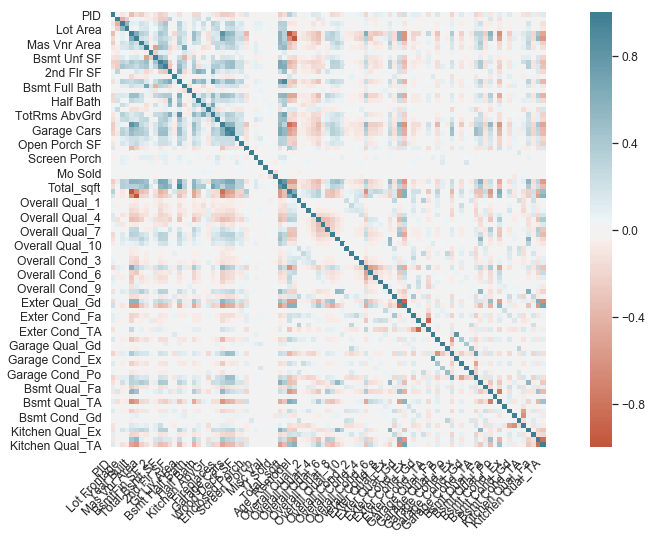

In [33]:
plt.rcParams['figure.figsize'] = (16, 8)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [34]:
corr['SalePrice'].sort_values(ascending=False).tail(20)

Overall Qual_6    -0.134270
Enclosed Porch    -0.135713
Overall Cond_3    -0.135845
Garage Cond_Fa    -0.143198
Bsmt Cond_Fa      -0.143498
Overall Qual_3    -0.151396
Kitchen Qual_Fa   -0.154897
Exter Cond_Fa     -0.155922
Overall Cond_4    -0.160003
Bsmt Qual_Fa      -0.161525
Garage Qual_Fa    -0.168164
Overall Cond_6    -0.191969
PID               -0.255068
Overall Qual_4    -0.269772
Overall Qual_5    -0.361157
Bsmt Qual_TA      -0.457260
Kitchen Qual_TA   -0.541265
Age_Remodel       -0.550872
Age_Build         -0.572405
Exter Qual_TA     -0.600974
Name: SalePrice, dtype: float64

In [35]:
Features_other = [
#,'MS Zoning'
#,'Street'
#,'Alley'
#,'Lot Shape'
#,'Land Contour'
#,'Utilities'
#,'Lot Config'
#,'Land Slope'
#,'Neighborhood'
#,'Condition 1'
#,'Condition 2'
#,'Bldg Type'
#,'House Style'
#,'Roof Style'
#,'Roof Matl'
#,'Exterior 1st'
#,'Exterior 2nd'
#,'Mas Vnr Type'
#,'Foundation'
#,'Bsmt Exposure'
#,'BsmtFin Type 1'
#,'BsmtFin Type 2'
#,'Heating'
#,'Heating QC'
#,'Central Air'
#,'Electrical'
#,'Functional'
#,'Fireplace Qu'
#,'Garage Type'
#,'Garage Finish'
#,'Paved Drive'
#,'Pool QC'
#,'Fence'
#,'Misc Feature'
#,'Sale Type'
]

In [36]:
Features_Num = [
#'PID'
#,'MS SubClass'
#,'Lot Frontage'
'Lot Area'
,'Year Built'
,'Year Remod/Add'
#,'Mas Vnr Area'
#,'BsmtFin SF 1'
#,'BsmtFin SF 2'
#,'Bsmt Unf SF'
,'Total Bsmt SF'
#,'1st Flr SF'
#,'2nd Flr SF'
#,'Low Qual Fin SF'
,'Gr Liv Area'
#,'Bsmt Full Bath'
#,'Bsmt Half Bath'
,'Full Bath'
,'Half Bath'
#,'Bedroom AbvGr'
#,'Kitchen AbvGr'
#,'TotRms AbvGrd'
#,'Fireplaces'
#,'Garage Yr Blt'
,'Garage Cars' #ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
,'Garage Area' #ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
#,'Wood Deck SF'
#,'Open Porch SF'
#,'Enclosed Porch'
#,'3Ssn Porch'
#,'Screen Porch'
#,'Pool Area'
#,'Misc Val'
#,'Mo Sold'
#,'Yr Sold'
#,'SalePrice'
,'Total_sqft'
,'Age_Build'
,'Age_Remodel'
#,'Overall Qual_1'
#,'Overall Qual_2'
#,'Overall Qual_3'
#,'Overall Qual_4'
#,'Overall Qual_5'
,'Overall Qual_6'
,'Overall Qual_7'
,'Overall Qual_8'
,'Overall Qual_9'
,'Overall Qual_10'
#,'Overall Cond_1'
#,'Overall Cond_2'
#,'Overall Cond_3'
#,'Overall Cond_4'
#,'Overall Cond_5'
,'Overall Cond_6'
,'Overall Cond_7'
,'Overall Cond_8'
,'Overall Cond_9'

#,'Exter Qual_Fa'
,'Exter Qual_TA'
,'Exter Qual_Gd'
,'Exter Qual_Ex'

#,'Exter Cond_Po'
#,'Exter Cond_TA'
#,'Exter Cond_Fa'
,'Exter Cond_Gd'
,'Exter Cond_Ex'
    
#,'Garage Qual_Fa'
#,'Garage Qual_Po'
#,'Garage Qual_TA'
,'Garage Qual_Gd'
#,'Garage Qual_Ex' #"['Bsmt Cond_Ex', 'Garage Qual_Ex'] not in index"

#,'Garage Cond_Fa'
#,'Garage Cond_Po'
#,'Garage Cond_TA'
,'Garage Cond_Gd'
,'Garage Cond_Ex'

#,'Bsmt Qual_Fa'
#,'Bsmt Qual_Po'
#,'Bsmt Qual_TA'
,'Bsmt Qual_Ex'
,'Bsmt Qual_Gd'


#,'Bsmt Cond_Fa'
#,'Bsmt Cond_Po'
#,'Bsmt Cond_TA'
,'Bsmt Cond_Gd'
#,'Bsmt Cond_Ex' #"['Bsmt Cond_Ex', 'Garage Qual_Ex'] not in index"

,'Kitchen Qual_TA'  
#,'Kitchen Qual_Fa'
,'Kitchen Qual_Ex'
,'Kitchen Qual_Gd'

]

In [37]:
#https://stackoverflow.com/questions/38462920/pandas-keyerror-value-not-in-index
#features_i = features + ['SalePrice']
#data = data.reindex(columns = features_i)
#KeyError: "['Bsmt Cond_Ex', 'Garage Qual_Ex'] not in index"



features = Features_other + Features_Num
X = data[features]
y = data['SalePrice']
X_eval = evaluate[features]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 23)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1536, 35)
(1536,)
(513, 35)
(513,)


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns = features)
X_test = pd.DataFrame(X_test,columns = features)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1536, 35)
(1536,)
(513, 35)
(513,)


In [40]:
lasso = Lasso(alpha = 10)
linreg = LinearRegression(lasso)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
;

''

In [41]:
predictors = X_train.columns
Series(linreg.coef_,predictors).sort_values(ascending=False)

Total_sqft         22801.905789
Overall Qual_9     15901.752187
Overall Qual_8     15313.130265
Overall Qual_10    12372.679761
Total Bsmt SF       8964.303836
Overall Qual_7      8310.889704
Exter Qual_Gd       7912.334534
Kitchen Qual_Ex     7255.890652
Lot Area            7209.085943
Exter Qual_Ex       7129.004507
Gr Liv Area         7098.576254
Year Built          6842.860412
Overall Cond_7      6288.069095
Bsmt Qual_Ex        6258.252323
Overall Cond_8      5160.088045
Exter Qual_TA       4477.047196
Kitchen Qual_Gd     4142.561929
Overall Cond_6      3792.902029
Kitchen Qual_TA     2798.443384
Overall Qual_6      2673.472061
Overall Cond_9      2623.314910
Garage Cars         2376.517218
Garage Qual_Gd      2132.959964
Garage Area         1746.565167
Year Remod/Add      1629.784492
Garage Cond_Ex       569.426025
Bsmt Qual_Gd         349.534085
Half Bath            147.905154
Bsmt Cond_Gd          52.971393
Exter Cond_Ex       -263.336109
Garage Cond_Gd      -494.472681
Exter Co

In [43]:
#having trouble plotting the coefficients
#plt.rcParams['figure.figsize'] = (10, 6)
#predictors = X_train.columns
#coef = Series(linreg.coef_,predictors).sort_values()
#coef.plot(kind='bar', title='Modal Coefficients');

#for idx, col_name in enumerate(X_train.columns):
    #print("The coefficient for {} is {}".format(col_name, linreg.coef_[idx]))


In [44]:

print("R-squared = ", linreg.score(X_test, y_test))  

print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R-squared =  0.9294127222391321
RMSE =  20727.976783962993


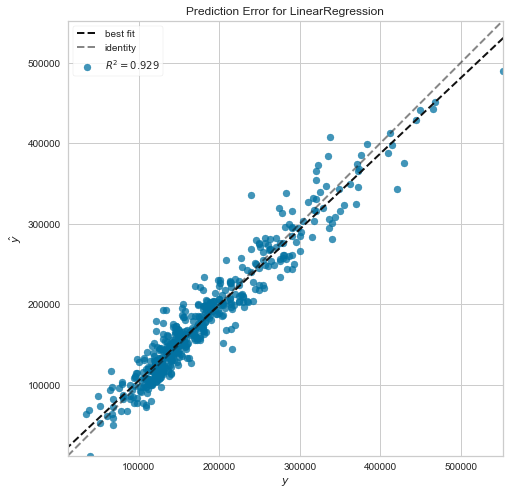

In [45]:
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

plt.rcParams['figure.figsize'] = (16, 8)

visualizer = PredictionError(linreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

#plt.scatter(y_test,y_pred)
#plt.xlabel('True Values')
#plt.ylabel('Predictions')


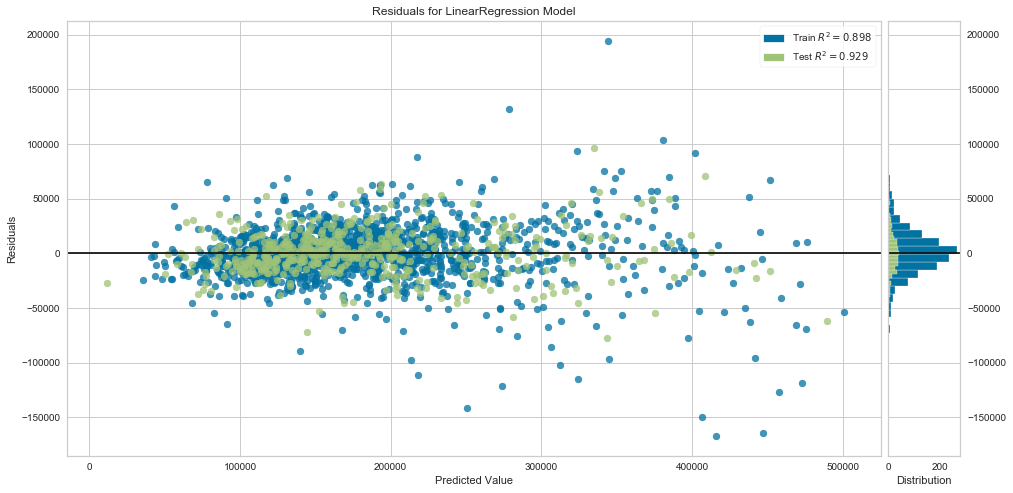

In [46]:
plt.rcParams['figure.figsize'] = (16, 8)

visualizer = ResidualsPlot(linreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [47]:
#set index for predictions with x_test
y_pred= pd.DataFrame(y_pred,index=X_test.index)
y_pred.rename(columns={y_pred.columns[0]:'Predicted_Price'}, inplace=True)

y_test= pd.DataFrame(y_test,index=X_test.index)
y_test.rename(columns={y_test.columns[0]:'Actual_Price'}, inplace=True)

X_test.index.name = 'Id'
y_test.index.name = 'Id'
y_pred.index.name = 'Id'

In [48]:
#dfs = (X_test,y_test,y_pred)
dfs = (data,y_test,y_pred)
#dfs = (data,y_train,y_pred)
results = reduce(lambda left,right: pd.merge(left,right,on = 'Id'),dfs)
results['DIF'] = abs(results['Actual_Price'] - results['Predicted_Price'])

results = results.sort_values(by = 'DIF',ascending= False)
results.to_csv('../data/LR_Lasso_data_E.csv')

In [49]:
#hapy with results train the model on the full data set and out put eval predictions
lasso_Eval = Lasso()
linreg_Eval = LinearRegression(lasso_Eval)
linreg_Eval.fit(X, y)
y_pred_eval = linreg_Eval.predict(X_eval)

y_pred_eval= pd.DataFrame(y_pred_eval,index=X_eval.index)
y_pred_eval.rename(columns={y_pred_eval.columns[0]:'SalePrice'}, inplace=True)
y_pred_eval.to_csv('../results/LR_Lasso_E.csv')

